# Machine Learning LAB 7: REINFORCEMENT LEARNING

Course 2025/26: *F. Chiariotti (notebook by P. Talli)*

The notebook contains some simple tasks about **REINFORCEMENT LEARNING**.

Complete all the **required code sections**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

### Content

In this lab we will implement and test two fundamental reinforcement learning algorithms: Q-Learning and SARSA. We will use a simple cliff environment to evaluate the performance of both agents.

In [1]:
# Library imports
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Define a class for the Environment
class SimpleCliffEnv:
    def __init__(self):
        """ Tile layout (36=start, 47=goal, 37-46=cliff)
        0	1	2	3	4	5	6	7	8	9	10	11
        12	13	14	15	16	17	18	19	20	21	22	23
        24	25	26	27	28	29	30	31	32	33	34	35
        36	37	38	39	40	41	42	43	44	45	46	47
        """
        self.nS = 48  # number of states
        self.nA = 4   # number of actions
        self.P = np.zeros((self.nS, self.nA, self.nS)) # transition probabilities
        self.R = np.zeros((self.nS, self.nA, self.nS)) # rewards

        # Define transitions and rewards
        for s in range(self.nS):
            for a in range(self.nA):
                if s == 47:  # goal state
                    self.P[s, a, s] = 1.0
                    self.R[s, a, s] = 0.0
                else:
                    next_s = self._get_next_state(s, a)
                    self.P[s, a, next_s] = 1.0
                    if next_s >= 37 and next_s <= 46:  # cliff states
                        self.R[s, a, next_s] = -100.0
                    else:
                        self.R[s, a, next_s] = -1.0

    def _get_next_state(self, s, a):
        row, col = divmod(s, 12) #putts s in a matrix of values using modulo 12 (number of columns) division
        if a == 0:  # action up
            row = max(row - 1, 0)
        elif a == 1:  # action right
            col = min(col + 1, 11)
        elif a == 2:  # action down
            row = min(row + 1, 3)
        elif a == 3:  # action left
            col = max(col - 1, 0)
        return row * 12 + col

In [4]:
# Define some utility functions
def print_policy(policy):
    action_symbols = ['↑', '→', '↓', '←']
    for i in range(4):
        row = ''
        for j in range(12):
            s = i * 12 + j
            if s == 47:
                row += ' G  '
            elif s >= 37 and s <= 46:
                row += ' C  '
            else:
                row += f' {action_symbols[policy[s]]}  '
        print(row)

def print_value_function(V):
    # Visualize the value function as a heatmap
    V_grid = V.reshape((4, 12))
    # Cliff states set to NaN for better visualization
    for s in range(37, 47):
        row, col = divmod(s, 12)
        V_grid[row, col] = np.nan
    plt.figure(figsize=(5,2.5))
    plt.imshow(V_grid, interpolation='nearest')
    # Without axes 
    plt.xticks([])
    plt.yticks([])
    # Colorbar horizontal, set lower bound to -100
    plt.colorbar(orientation='horizontal')
    plt.title('Value Function Heatmap')
    plt.show()

 ↑   →   →   ←   →   ↓   ↓   ←   ↑   ↓   ↓   ←  
 ↓   ↑   ←   →   →   →   ↓   →   →   →   ←   ←  
 ↑   ↑   ↑   ←   ↓   ↓   ↓   ↑   ↑   ↓   ←   →  
 →   C   C   C   C   C   C   C   C   C   C   G  


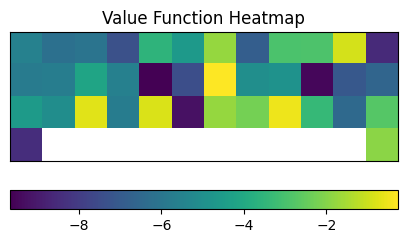

In [5]:
policy = np.random.choice(4, size=48)  # Random policy for demonstration
V = np.random.rand(48) * -10  # Random value function for demonstration
print_policy(policy)
print_value_function(V)

In [7]:
# Define a Policy Evaluation function
def policy_evaluation(env, policy, theta=1e-6, discount_factor=0.99):
    """This function takes a policy and an environment and returns the
    value function for that policy.
    Args:
        env: The environment to evaluate the policy on.
        policy: The policy to evaluate. [nS x nA] shaped matrix
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    """
    V = np.zeros(env.nS)
    while True:
        delta = 0 # Variable that tracks the maximum change in the value function
        for s in range(env.nS):
            ### TODO: implement the policy evaluation function
        if delta < theta:
            break
    return V

Remember what a value function represents

$$V^\pi(s) = \mathbb{E}_\pi \left[ \sum_{t=0}^{\infty} \gamma^t r_t \mid s_0 = s \right]$$

It is the expected cumulative reward starting from state $s$ and following policy $\pi$.
It can be computed iteratively using the Bellman expectation equation:
$$V^\pi(s) = \sum_{a} \pi(a|s) \sum_{s', r} p(s'| s, a) \left[ r(s, a, s') + \gamma V^\pi(s') \right]$$

With ```policy_evaluation``` function we can evaluate stochastic policies where the action taken in each state is not deterministic.

$$\pi(a|s) = Prob(A_t = a | S_t = s)$$

Let's test a uniform random policy in the cliff environment.

In [ ]:
policy = np.ones((48, 4))  # Uniform random policy
policy = policy / policy.sum(axis=1, keepdims=True)  # Normalize to get probabilities
V = policy_evaluation(SimpleCliffEnv(), policy)
print_value_function(V)

We can notice that the value function is very low in states close to the cliff, as the agent is likely to fall off and incur a large negative reward. 
The value function increases as we move away from the cliff, indicating that the agent is more likely to reach the goal without falling off.

### Q-Learning Agent
Now let's implement and test a Q-Learning agent in the cliff environment. Q-Learning is an off-policy algorithm that learns the optimal action-value function, which can be used to derive the optimal policy.

Q value function:
$$Q^*(s, a) = \mathbb{E} \left[ r_t + \gamma \max_{a'} Q^*(s_{t+1}, a') \mid s_t = s, a_t = a \right]$$

Update rule:
$$Q(s, a) \gets Q(s, a) + \alpha \left( r_t + \gamma \max_{a'} Q(s_{t+1}, a') - Q(s, a) \right)$$

To explore the action space we use an epsilon-greedy policy, which selects a random action with probability epsilon, and the action that maximizes the Q-value with probability 1-epsilon.

$$ \pi(a|s) = \begin{cases} \frac{\epsilon}{|A(s)|} & \text{if } a \neq \arg\max_{a'} Q(s, a') \\ 1 - \epsilon + \frac{\epsilon}{|A(s)|} & \text{if } a = \arg\max_{a'} Q(s, a') \end{cases} $$

In [ ]:
# Q Learning Implementation
# With epsilon-greedy action selection
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.99, exploration_prob=0.1):
        self.env = env
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_prob
        self.Q = np.zeros((env.nS, env.nA))

    def choose_action(self, state):
        ### TODO Implement an epsilon-greedy policy (the function should return a valid action index)

    def learn(self, state, action, reward, next_state):
        ### TODO Update the Q-value table following the Q-learning algorithm

In [ ]:
def get_greedy_policy(Q):
    policy = np.zeros(Q.shape[0], dtype=int)
    for s in range(Q.shape[0]):
        policy[s] = np.argmax(Q[s])
    return policy

def get_max_q_values(Q):
    V = np.max(Q, axis=1)
    return V

def training_loop(env, agent, num_episodes=500):
    for episode in range(num_episodes):
        if episode % 200 == 0:
            policy = get_greedy_policy(agent.Q)
            print_policy(policy)
            V = get_max_q_values(agent.Q)
            print_value_function(V)
        state = 36  # Start state
        done = False
        while not done:
            action = agent.choose_action(state)
            next_state_probs = env.P[state, action]
            next_state = np.random.choice(np.arange(env.nS), p=next_state_probs)
            reward = env.R[state, action, next_state]
            agent.learn(state, action, reward, next_state)
            state = next_state
            if state == 47:  # Goal state
                done = True

Test the Q-Learning agent in the cliff environment for 1000 episodes.

In [ ]:
q_agent = QLearningAgent(SimpleCliffEnv(), exploration_prob=0.1)
num_episodes = 1000

training_loop(SimpleCliffEnv(), q_agent, num_episodes)
policy = get_greedy_policy(q_agent.Q)
print_policy(policy)
V = get_max_q_values(q_agent.Q)
print_value_function(V)


# SARSA Agent
Now let's implement and test a SARSA agent in the cliff environment. SARSA is an on-policy algorithm that learns the action-value function for the policy being followed.
SARSA value function:
$$Q^\pi(s, a) = \mathbb{E}_\pi \left[ r_t + \gamma Q^\pi(s_{t+1}, a_{t+1}) \mid s_t = s, a_t = a \right]$$

Update rule:
$$Q(s, a) \gets Q(s, a) + \alpha \left( r_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s, a) \right)$$

In [ ]:
# SARSA Implementation
class SARSAAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.99, exploration_prob=0.1):
        self.env = env
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_prob
        self.Q = np.zeros((env.nS, env.nA))

    def choose_action(self, state):
        ### TODO Implement an epsilon-greedy policy (the function should return a valid action index)


    def learn(self, state, action, reward, next_state, next_action):
        ### TODO Update the Q-value table following the SARSA algorithm (remember the difference with Q-learning!)

def sarsa_training_loop(env, agent, num_episodes=500):
    for episode in range(num_episodes):
        state = 36  # Start state
        action = agent.choose_action(state)
        done = False
        while not done:
            next_state_probs = env.P[state, action]
            next_state = np.random.choice(np.arange(env.nS), p=next_state_probs)
            reward = env.R[state, action, next_state]
            next_action = agent.choose_action(next_state)
            agent.learn(state, action, reward, next_state, next_action)
            state = next_state
            action = next_action
            if state == 47:  # Goal state
                done = True

In [ ]:
# Test SARSA Agent
sarsa_agent = SARSAAgent(SimpleCliffEnv(), exploration_prob=0.1)
sarsa_training_loop(SimpleCliffEnv(), sarsa_agent, num_episodes=1000)
policy = get_greedy_policy(sarsa_agent.Q)
print_policy(policy)
V = get_max_q_values(sarsa_agent.Q)
print_value_function(V)

We can notice that the value function learned by the SARSA agent is generally lower than that of the Q-Learning agent, especially in states close to the cliff. This is because SARSA takes into account the action taken in the next state, which may lead to falling off the cliff, while Q-Learning always assumes the best possible action will be taken. As a result, SARSA tends to be more conservative in its value estimates, leading to a safer policy that avoids risky actions near the cliff.

In [ ]:
# Compare with values of an optimal policy
optimal_policy = np.zeros(48, dtype=int)
for s in range(48):
    if s < 36:
        optimal_policy[s] = 1  
    elif s >= 36 and s < 47:
        optimal_policy[s] = 0 
    if s % 12 == 11:
        optimal_policy[s] = 2 
print_policy(optimal_policy)
policy = np.eye(4)[optimal_policy] # One-hot encoding to get [nS x nA] shape
optimal_V = policy_evaluation(SimpleCliffEnv(), policy)
print_value_function(optimal_V)